In [1]:
import pandas as pd
import stumpy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.patches import Rectangle
from matplotlib import animation
from matplotlib.figure import Figure
import matplotlib.gridspec as gridspec
from IPython.display import HTML
import os
import datetime as dt
import panel as pn

pn.extension()

plt.style.use('https://raw.githubusercontent.com/TDAmeritrade/stumpy/main/docs/stumpy.mplstyle')

In [2]:
ticker= (
    'BTCUSD' 
)



res = 'Day'
# res = 'Week'
# res = 'Month'
# res = 'Quarter'
# res = 'Year'

exportPath = './'
marketPath = './'
imgPath = './'
tmpPath = './'


_df = pd.read_csv(marketPath + ticker + '.csv',parse_dates = True,index_col=0)

if res == 'Day':
    _df = _df.resample('D').mean() 
elif res == 'Week':
    _df = _df.resample('W-MON').mean()    
elif res == 'Month':
    _df = _df.resample('MS').first()
elif res == 'Quarter':
    _df = _df.resample('Q').mean()    
elif res == 'Year':
    _df = _df.resample('Y').mean() 


_df['y'] = _df['close']


def log_transform(df):
    # copy the dataframe
    tdf = df.copy()
    # apply log scaling
    for column in tdf.columns:
        tdf[column] = np.log(tdf[column])

    tdf.replace([np.inf, -np.inf], np.nan, inplace=True)
    tdf = tdf.astype(float)
    tdf = tdf.interpolate(method='linear', axis=0).ffill().bfill()
#     tdf = tdf.dropna(axis='columns')
    tdf = tdf.fillna(0)

    return tdf

def min_max_scaling(df):
    # copy the dataframe
    tdf = df.copy()
    # apply min-max scaling
    for column in tdf.columns:
        tdf[column] = (tdf[column] - tdf[column].min()) / (tdf[column].max() - tdf[column].min())
#     tdf = tdf.dropna(axis='columns')
    tdf = tdf.fillna(0)
    return tdf

    
_df = log_transform(_df)

df_index = _df.index

df = _df.reset_index(drop=True)

/home/u1/Apps/anaconda3/envs/stumpy/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [3]:
def get_value(dictionary, key, default_value):
    return dictionary.get(key, default_value)

ticker_dict = {
    # 'BTCUSD': 'GOLD', 
    # 'BTCUSD': 'NDX',
    'BTCUSD': 'SPX',    
}

ticker1 = get_value(ticker_dict, ticker, None)
print(ticker1)  # Output: 1



SPX


In [4]:
res = 'Day'
# res = 'Week'
# res = 'Month'
# res = 'Quarter'
# res = 'Year'

exportPath = './'
marketPath = './'
imgPath = './'
tmpPath = './'


# --------------------------------------------------------------------------------------------------------------------------------------------
_df1 = pd.read_csv(marketPath + ticker1 + '.csv',parse_dates = True,index_col=0)
    
_df1 = log_transform(_df1)

df1_index = _df1.index

df1 = _df1.reset_index(drop=True)

/home/u1/Apps/anaconda3/envs/stumpy/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


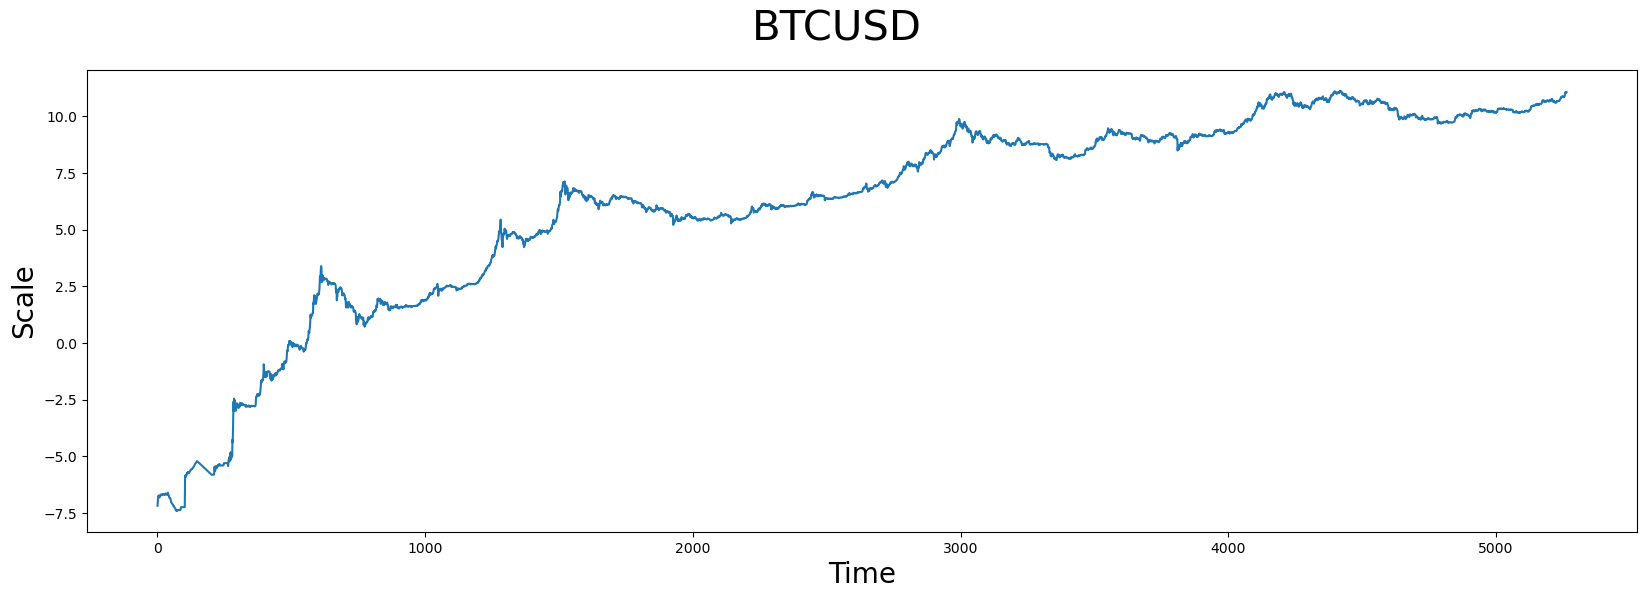

In [5]:
plt.suptitle(ticker, fontsize='30')
plt.xlabel('Time', fontsize ='20')
plt.ylabel('Scale', fontsize='20')
plt.plot(df['close'])
plt.show()

In [6]:
mps = {}
m = 119

for colname in df.columns:
    mps[colname] = stumpy.gpu_stump(
    T_A = df['close'],
    m = m,
        
    T_B = df1['close'],
    ignore_trivial = False
)
    

/home/u1/Apps/anaconda3/envs/stumpy/lib/python3.10/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 11 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


5146


Column
    [0] Row
        [0] Select(options=['close', 'high', ...], value='close', width=100)
        [1] CheckButtonGroup(name='Normalize', options=['Z-Normalize'], value=['Z-Normalize'], width=100)
        [2] TextInput(value='5146', width=100)
        [3] IntSlider(end=10264, value=5146, width=800)
    [1] Row
        [0] Matplotlib(Figure)
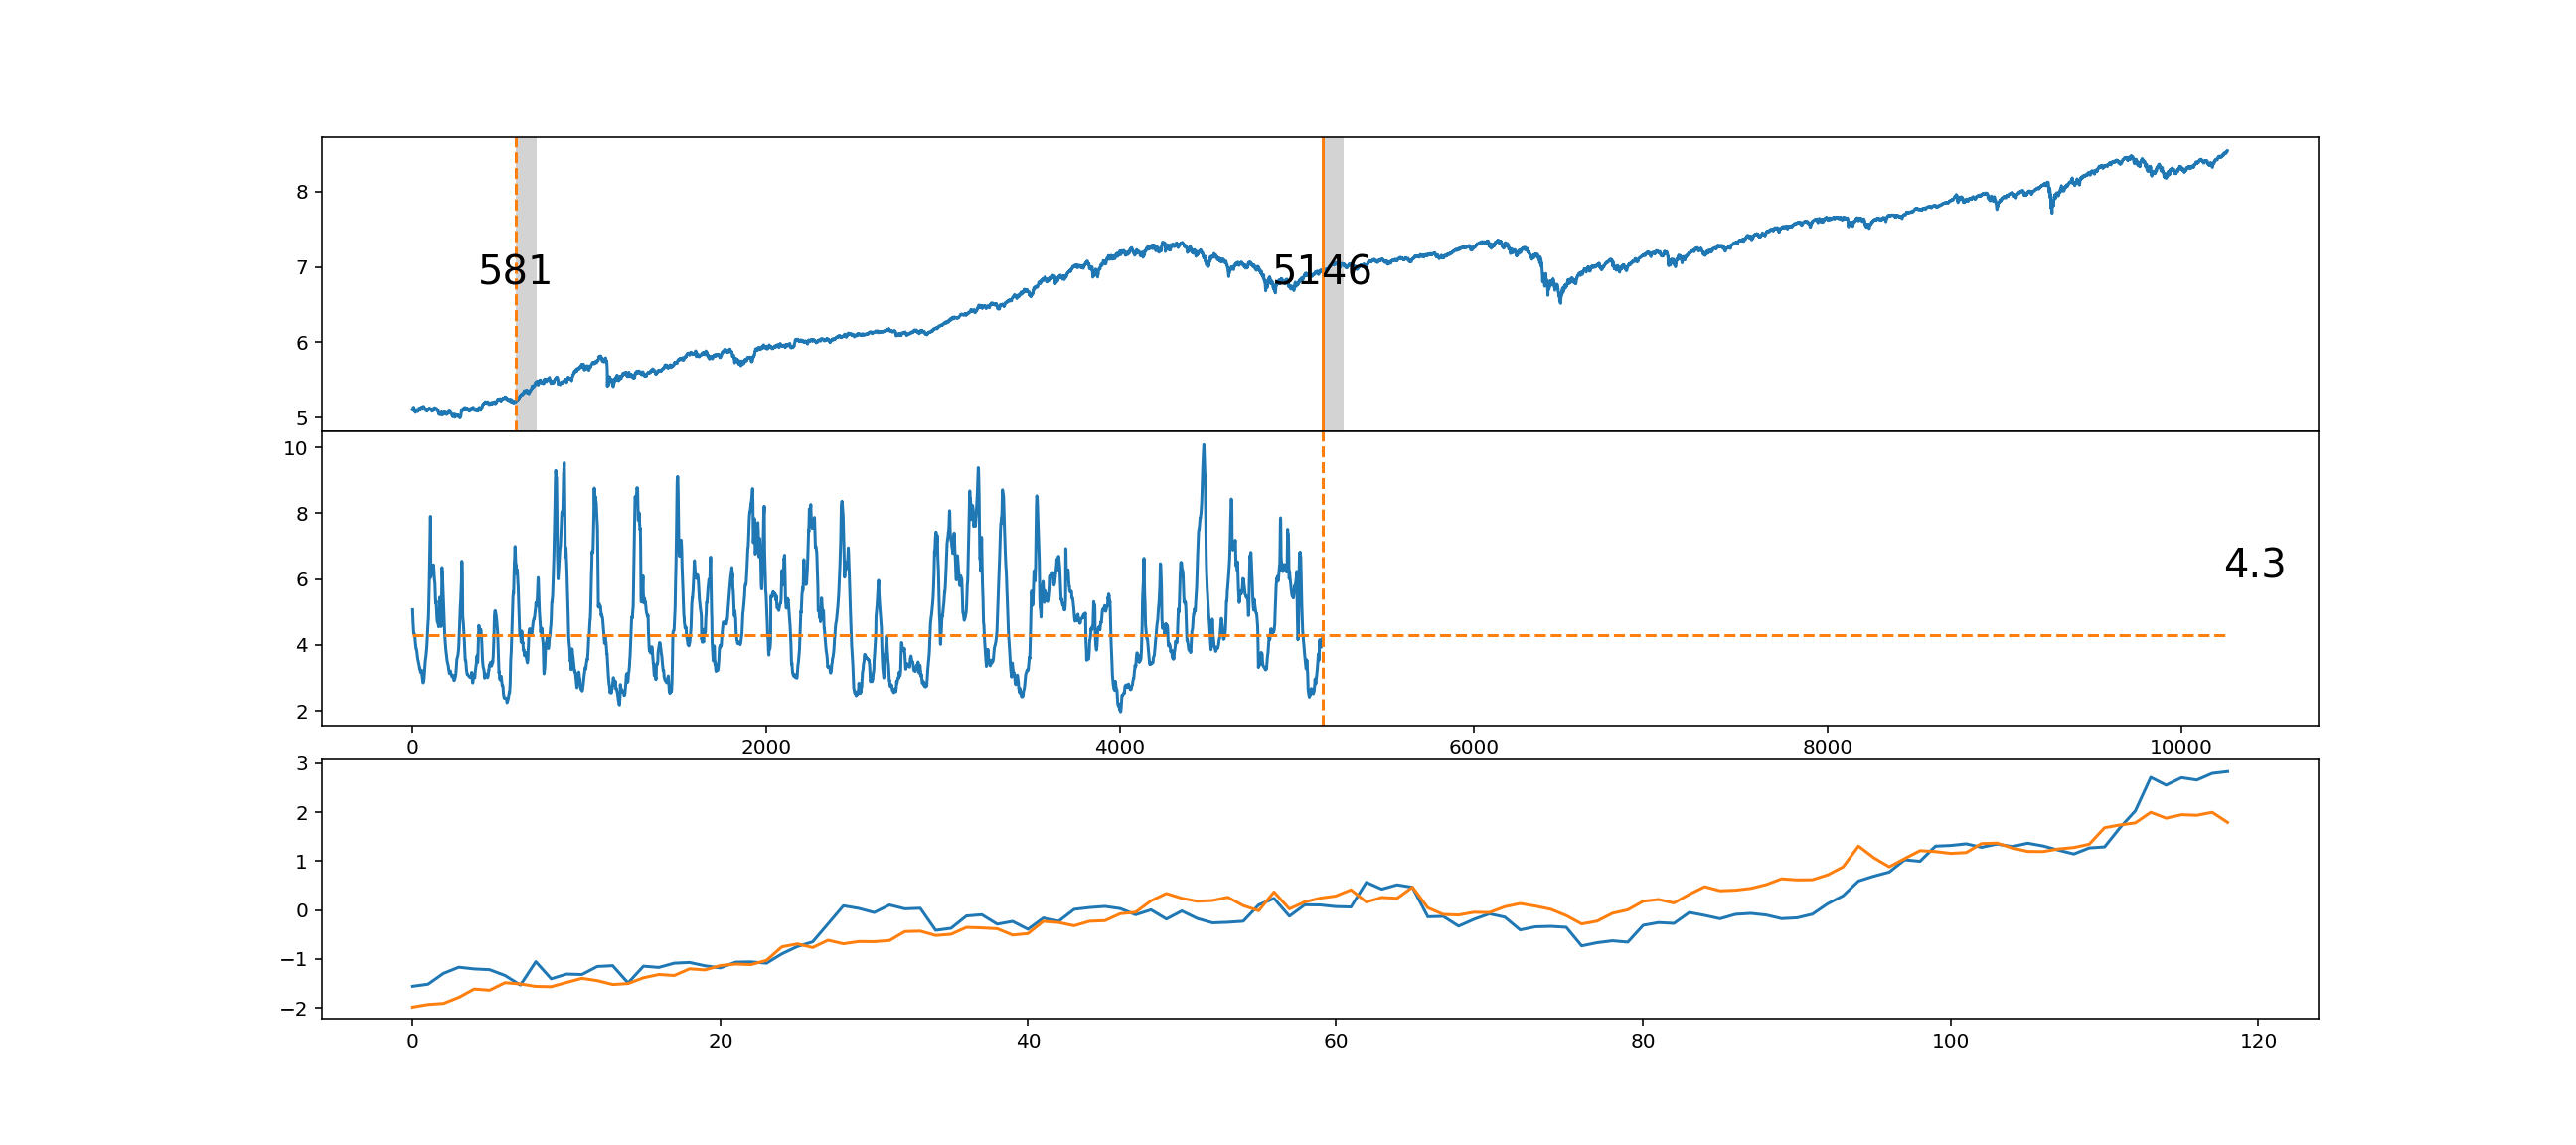

In [7]:
current_idx_start = len(df)-m
print(current_idx_start)
subset_start_idx = []


select_plot = pn.widgets.Select(name='', options=sorted(list(df1.columns)), width=100)
normalize_btn = pn.widgets.CheckButtonGroup(name='Normalize', value=['Z-Normalize'], options=['Z-Normalize'], width=100)
idx_slider = pn.widgets.IntSlider(value=0, start=0, end=len(df1), width=800)
txt_input = pn.widgets.TextInput(value="0", width=100)

def display_raw(df1, mps, colname, m=m, idx=None):
    fig = Figure(figsize=(18,8))
    shared_spec = gridspec.GridSpec(3, 1, hspace=0)
    unshared_spec = gridspec.GridSpec(3, 1)
    raw_ax = fig.add_subplot(shared_spec[0, :])
    mp_ax = fig.add_subplot(shared_spec[1, :], sharex=raw_ax)
    overlap_ax = fig.add_subplot(unshared_spec[2, :])
    
    raw_ax.plot(df1[colname])
    
    mp = mps[colname]
    mp_ax.plot(mp[:, 0])
    
    if idx is None:
        # idx = int(np.argsort(mp[:, 0])[0])
        idx = current_idx_start
    nn_idx = mp[:, 1][idx]
    distance = mp[idx, 0]
    subset_start_idx.append(nn_idx)
    
    idx_slider.value = idx
    txt_input.value = str(idx)
    
    y_midpoint = (raw_ax.get_ylim()[1] + raw_ax.get_ylim()[0]) / 2

    raw_ax.text(idx, y_midpoint, str(idx), color="black", fontsize=20, ha='center')
    raw_ax.text(nn_idx, y_midpoint, str(nn_idx), color="black", fontsize=20, ha='center')
    
    raw_ax.axvline(x=idx, color="C1")
    raw_ax.axvline(x=nn_idx, linestyle="dashed", color="C1")
    
    rect = Rectangle((idx, 0), m, 40, facecolor='lightgrey')
    raw_ax.add_patch(rect)
    rect = Rectangle((nn_idx, 0), m, 40, facecolor='lightgrey')
    raw_ax.add_patch(rect)
    
    mp_ax.axvline(x=idx, linestyle="dashed", color="C1")
    mp_ax.hlines(distance, 0, len(df1), linestyle="dashed", color="C1")
    ymin, ymax = mp_ax.get_ylim()
    xmin, xmax = mp_ax.get_xlim()
    mp_ax.text(xmax * 0.95, ymin+(ymax-ymin)/2, f'{np.round(distance,1)}', color="black", fontsize=20)

    # Need to z-normalize
    if 'Z-Normalize' in normalize_btn.value:
        overlap_ax.plot(stumpy.core.z_norm(df[colname].values[idx:idx+m]))
        overlap_ax.plot(stumpy.core.z_norm(df1[colname].values[nn_idx:nn_idx+m]))  
    else:
        overlap_ax.plot(df[colname].values[idx:idx+m])
        overlap_ax.plot(df1[colname].values[nn_idx:nn_idx+m])

    return fig
 

plot = pn.Row(display_raw(df1, mps, "close"), align='start')


def replace_plot(event):
    colname = event.new
    plot[0] = display_raw(df1, mps, colname=colname)

    
def update_plot(event):
    colname = select_plot.value
    plot[0] = display_raw(df1, mps, colname=colname)


def move_idx(event):
    idx = event.new
    txt_input.value = str(idx)
    colname = select_plot.value
    plot[0] = display_raw(df1, mps, colname=colname, idx=idx)


def update_slider(event):
    idx = int(event.new)
    idx_slider.value = idx
    colname = select_plot.value
    plot[0] = display_raw(df1, mps, colname=colname, idx=idx)
    

select_plot.param.watch(replace_plot, 'value')
normalize_btn.param.watch(update_plot, 'value')
txt_input.param.watch(update_slider, 'value' )
idx_slider.param.watch(move_idx, 'value')

p = pn.Column(
        pn.Row(select_plot, normalize_btn, txt_input, idx_slider),
        plot,
    )

p

In [8]:
print(len(df)-m)

current_idx_start = len(df)-m

5146


In [9]:
p.save("test.html")

In [10]:
# zdf = pd.DataFrame({'timestamp': df_index})
zdf = df
zdf['timestamp'] = df_index
zdf = zdf.set_index('timestamp')
print(zdf)


zdf1 = df1
zdf1['timestamp'] = df1_index
zdf1 = zdf1.set_index('timestamp')
print(zdf1)

                 open       high        low      close     volume          y
timestamp                                                                   
2009-10-05  -7.177047  -7.177047  -7.177047  -7.177047   2.995732  -7.177047
2009-10-06  -7.030443  -7.030443  -7.030443  -7.030443   2.995732  -7.030443
2009-10-07  -6.858584  -6.858584  -6.858584  -6.858584   2.995732  -6.858584
2009-10-08  -6.826839  -6.826839  -6.826839  -6.826839   2.995732  -6.826839
2009-10-09  -6.725059  -6.725059  -6.725059  -6.725059   2.995732  -6.725059
...               ...        ...        ...        ...        ...        ...
2024-02-29  11.042505  11.060844  11.006384  11.021346  10.854646  11.021346
2024-03-01  11.021277  11.053704  11.014067  11.041573  10.399320  11.041573
2024-03-02  11.041469  11.042498  11.028887  11.035224   9.334431  11.035224
2024-03-03  11.033827  11.054898  11.024921  11.053251   9.367573  11.053251
2024-03-04  11.053217  11.058909  11.051714  11.058069   6.380939  11.058069

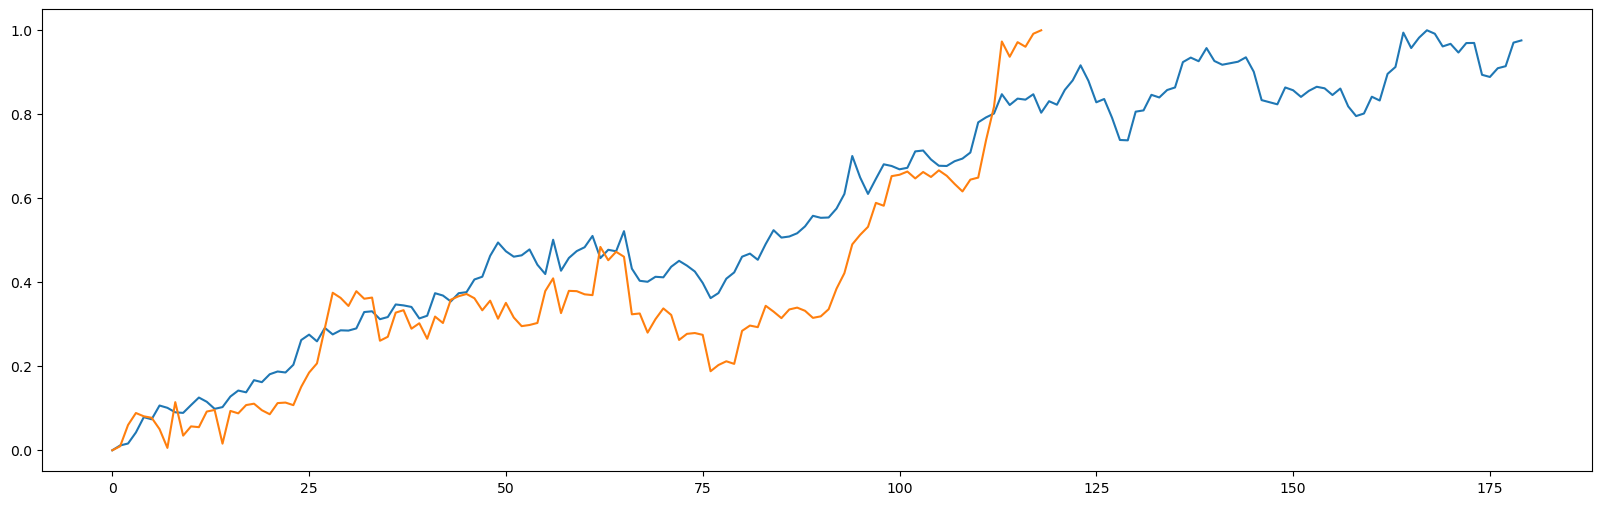

In [11]:
start_idx = subset_start_idx[0]

# start_idx = 5771
end_idx = round(start_idx+m*1.5)

# Extract the range of values using iloc
subset1 = zdf1.iloc[start_idx:end_idx+1]


start_idx = current_idx_start
# start_idx = 4869
end_idx = start_idx+m

# Extract the range of values using iloc
subset2 = zdf.iloc[start_idx:end_idx+1]

subset1 = min_max_scaling(subset1)
subset2 = min_max_scaling(subset2)

plt.plot(subset1['close'].reset_index(drop=True))
plt.plot(subset2['close'].reset_index(drop=True))

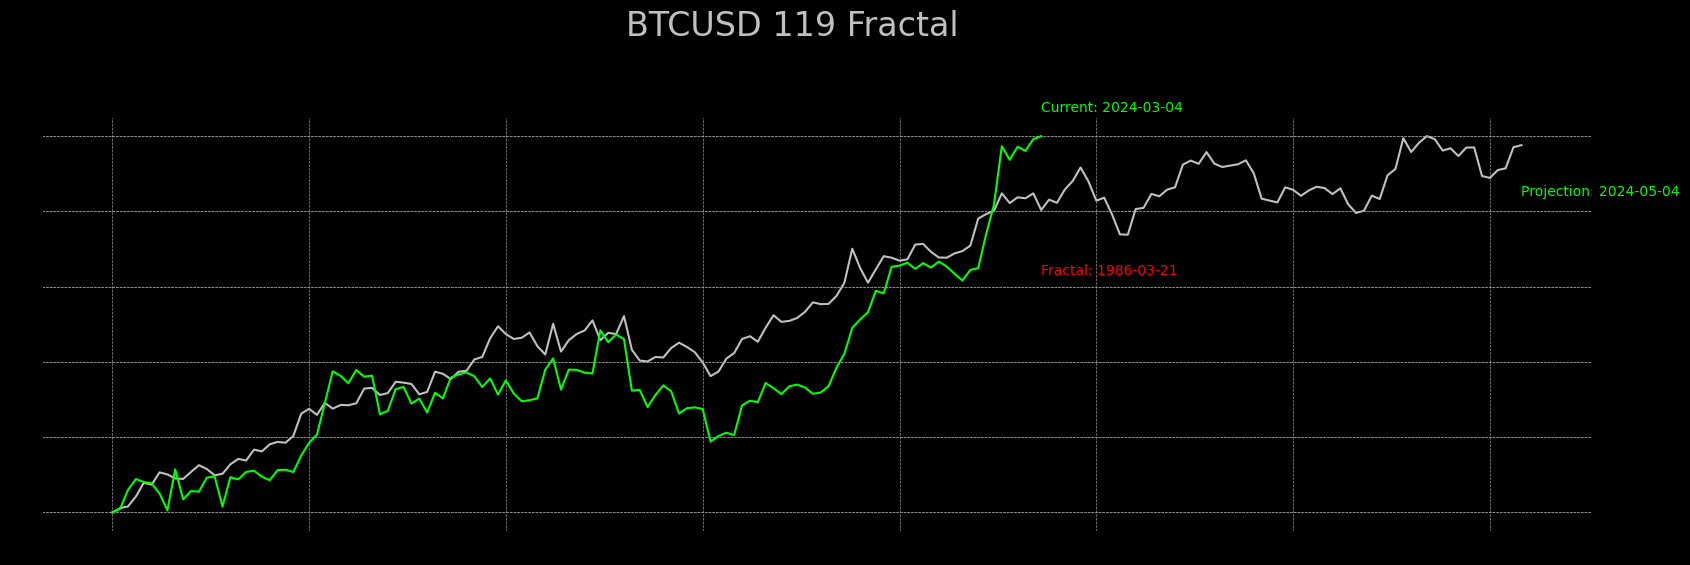

In [12]:
import matplotlib.pyplot as plt

fig = plt.figure(facecolor='black')
fig.set_edgecolor('black')

ax = fig.add_subplot(label="1", facecolor='black')
ax2 = ax.twinx()  # create a twin of ax that shares the x-axis

color_ax = '#C0C0C0'
color_ax2 = '#00FF00'

subset1_reset = subset1['close'].reset_index(drop=True)
subset2_reset = subset2['close'].reset_index(drop=True)


ax.plot(subset1_reset, color=color_ax)
ax2.plot(subset2_reset, color=color_ax2)

# ax.tick_params(axis='both', colors=color_ax, which='major', labelsize=15)
# ax2.tick_params(axis='both', colors=color_ax2, which='major', labelsize=15)

# Find the index in subset2 that matches the last index of subset1
match_index = len(subset2) - 1
match_index_sub1 = len(subset1) - 1

import datetime

# Label the matching index with text annotation
start_date = subset2.index[match_index].strftime('%Y-%m-%d')
date_1 = datetime.datetime.strptime(start_date, "%Y-%m-%d")
date_2 = date_1 + datetime.timedelta(days=len(subset1)-len(subset2))

ax.annotate('Fractal: ' + subset1.index[match_index].strftime('%Y-%m-%d'), 
            xy=(match_index, subset1_reset.iloc[match_index]), 
            xytext=(match_index, subset1_reset.iloc[match_index] - subset1_reset.std()/2), 
            color='red', ha='left', va='top')

ax2.annotate('Current: ' + subset2.index[match_index].strftime('%Y-%m-%d'), 
             xy=(match_index, subset2_reset.iloc[match_index]), 
             xytext=(match_index, subset2_reset.iloc[match_index] + subset2_reset.std() /4), 
             color=color_ax2, ha='left', va='bottom')

ax.annotate('Projection: ' + date_2.strftime('%Y-%m-%d'), 
            xy=(match_index_sub1, subset1_reset.iloc[match_index_sub1]), 
            xytext=(match_index_sub1, subset1_reset.iloc[match_index_sub1] - subset1_reset.std()/2), 
            color=color_ax2, ha='left', va='bottom')



title = ticker + ' ' + str(m) + ' Fractal'
# title = ticker +  ' Fractal'
fig.suptitle(title, fontsize=24, fontweight='regular', color='#C0C0C0')

fig.subplots_adjust(top=0.8)

grid_style = {'linewidth': 0.5, 'color': '#999999', 'linestyle': '--'}
ax.grid(True, **grid_style)
ax2.grid(True, **grid_style)

plt.savefig(imgPath + title + '.png', dpi=300, bbox_inches='tight', facecolor='black')

plt.show()
